In [1]:
import os
import sys
import pickle
import random
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import pandas as pd
import numpy as np

from pycox.datasets import kkbox_v1
from sklearn.model_selection import ParameterGrid
sys.path.append("../")

from tools import test_quality, preprocess_kkbox, transform_kkbox

# Diagnostic run

<b>Goal: </b>  to find appropriate hyperparameters values ranges to fit models

Set random seed

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

Data

In [3]:
df_train = kkbox_v1.read_df(subset='train')
df_test = kkbox_v1.read_df(subset='test')
df_val = kkbox_v1.read_df(subset='val')

x_train, t_train, y_train = preprocess_kkbox(df_train)
x_val, t_val, y_val = preprocess_kkbox(df_val)
x_test, t_test, y_test = preprocess_kkbox(df_test)

x_train, x_test, x_val = transform_kkbox(x_train, x_test, x_val)
data = {
    'train': {
        'x': x_train,
        'y': y_train,
        't': t_train
    },
    'test': {
        'x': x_test,
        'y': y_test,
        't': t_test            
    },
    'val': {
        'x': x_val,
        'y': y_val,
        't': t_val            
        }
    }

## 1. Find alpha and beta parameters of Weibull distribution

<b>Goal: </b>  to understand which alpha and beta are optimal for all population and define appropriate ranges for related hyperparameters

In [4]:
from losses import calc_likelyhood

Set alpha and beta parameter grid

In [5]:
alpha = [1e-1, 1e0, 1e2, 1e3, 1e4]
beta = np.linspace(0.5, 2, 15)
params = ParameterGrid({'alpha': alpha, 'beta': beta})

In [6]:
tf.reset_default_graph()
alpha_pl = tf.placeholder(dtype=tf.float64, name='alpha')
beta_pl = tf.placeholder(dtype=tf.float64, name='beta')
ll = calc_likelyhood(alphas=alpha_pl, betas=beta_pl, t=data['train']['t'], y=data['train']['y'].astype(float))
all_res = []
with tf.Session() as sess:
    tf.set_random_seed(s)
    init = tf.initialize_all_variables()
    sess.run(init)
    for par in tqdm.tqdm_notebook(params):
        lh = sess.run(ll, feed_dict={
            alpha_pl: np.repeat(par['alpha'], data['train']['t'].shape[0]), 
            beta_pl: np.repeat(par['beta'], data['train']['t'].shape[0])
        })
        all_res.append({'lh': -1*np.mean(lh), 'alpha': par['alpha'], 'beta': par['beta']})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [7]:
df = pd.DataFrame(all_res)
df.head()

,lh,alpha,beta
0,37.618964,0.1,0.500000
1,89.520428,0.1,0.607143
2,214.664744,0.1,0.714286
3,518.081562,0.1,0.821429
4,1258.434071,0.1,0.928571


In [10]:
df['lh'].quantile([0.5, 0.7, 0.8, 0.9])

0.5        6.094486
0.7      200.992722
0.8     3253.401451
0.9    53826.269713
Name: lh, dtype: float64

In [11]:
df.loc[df['lh'] > 200, 'lh'] = 200

In [12]:
df_plot = df.pivot('alpha', 'beta', 'lh')

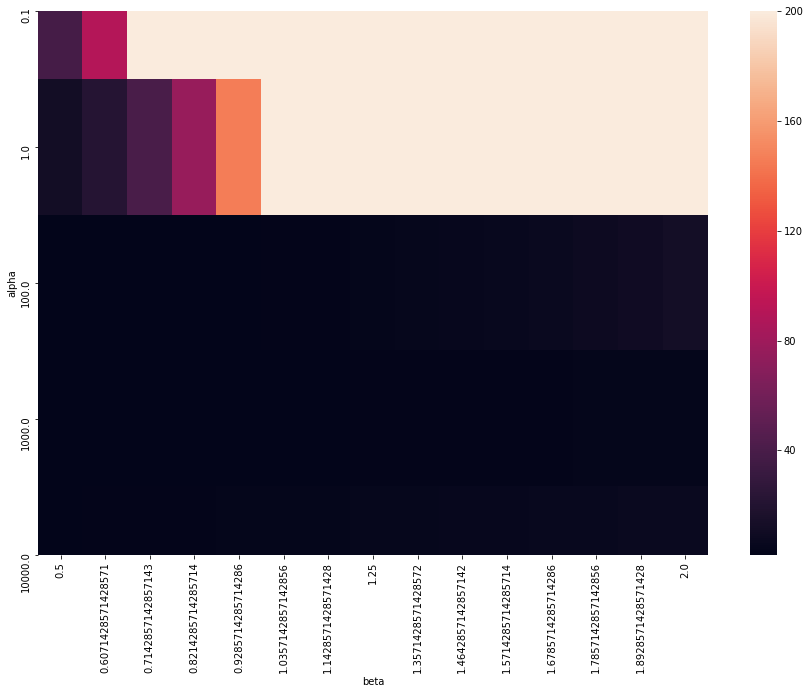

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_plot);

In [14]:
df_plot = df[df['alpha'] >= 100].pivot('alpha', 'beta', 'lh')

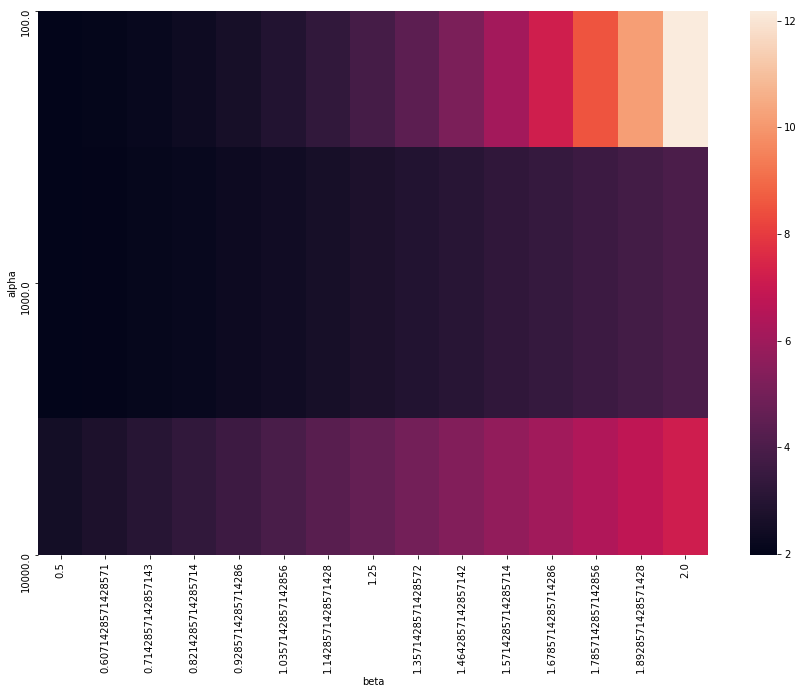

In [15]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_plot);

Grid search over more precise grid

In [16]:
alpha = np.linspace(100, 1000, 50)
beta = np.linspace(0.5, 1, 7)
params = ParameterGrid({'alpha': alpha, 'beta': beta})

In [17]:
tf.reset_default_graph()
alpha_pl = tf.placeholder(dtype=tf.float64, name='alpha')
beta_pl = tf.placeholder(dtype=tf.float64, name='beta')
ll = calc_likelyhood(alphas=alpha_pl, betas=beta_pl, t=data['train']['t'], y=data['train']['y'].astype(float))
all_res = []
with tf.Session() as sess:
    tf.set_random_seed(s)
    init = tf.initialize_all_variables()
    sess.run(init)
    for par in tqdm.tqdm_notebook(params):
        lh = sess.run(ll, feed_dict={
            alpha_pl: np.repeat(par['alpha'], data['train']['t'].shape[0]), 
            beta_pl: np.repeat(par['beta'], data['train']['t'].shape[0])
        })
        all_res.append({'lh': -1*np.mean(lh), 'alpha': par['alpha'], 'beta': par['beta']})

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [18]:
df = pd.DataFrame(all_res)
df.head()

,lh,alpha,beta
0,2.007124,100.0,0.500000
1,2.048388,100.0,0.583333
2,2.127007,100.0,0.666667
3,2.242059,100.0,0.750000
4,2.394332,100.0,0.833333


Minimal loss - `1.87` achieved with `alpha = 302` and `beta = 0.58`

In [23]:
df.sort_values('lh').head(1).values

array([[  1.86821109, 302.04081633,   0.58333333]])

With fixed alpha how loss depends on beta parameter value

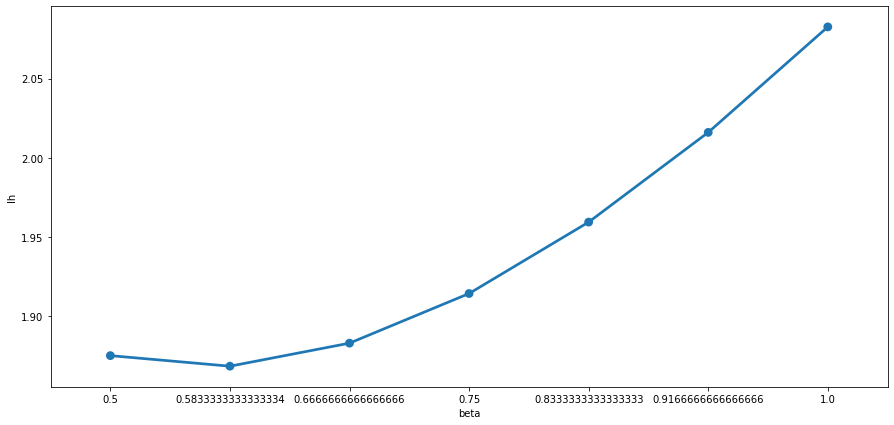

In [45]:
plt.figure(figsize=(15, 7))
sns.pointplot(data=df[(df['alpha'] >= 302) & (df['alpha'] <= 303)], x='beta', y='lh')

With fixed beta how loss depends on alpha parameter value

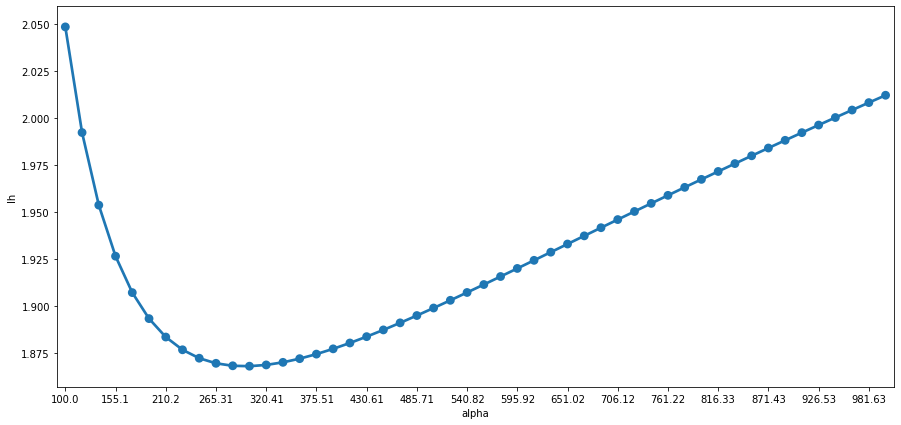

In [56]:
fig = plt.figure(figsize=(15, 7))
ax = sns.pointplot(data=df[(df['beta'] >= 0.58) & (df['beta'] <= 0.59)], x='alpha', y='lh');
fig.canvas.draw()
new_ticks = [round(float(i.get_text()), 2) for i in ax.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 3), new_ticks[::3]);

<b> Neural network weights initialization </b> 

In simple Weibull model user specified bottom layers are stacked with one-layer head where alpha and beta outputs are calculated using different activation functions.

# here should be formula!!!!

It could be seen that to get output <b> alpha </b> value linear projection of output is clipped to `[0; 12]` interval (to prevent infinity values) which is followed by exponential activation

Similarly, to get output <b> beta </b> value linear projection of output is clipped to `[0; 2]` interval which is followed by softplus activation

By default biases and weight matrices are initialized by random normal distribution with `mean = 0` and `std dev = 1`. 
Sometimes this variation is too small and optimizer fails to find good enough alpha and beta parameters (for example when optimal alpha is high).
In these cases it is needed to introduce more variation to make a network explore higher 'alpha' output value ranges during optimization.
To approach this issue you can specify alpha_bias_random_mean (mean of random normal distribution for alpha bias), alpha_random_stddev (stddev of random normal distribution for alpha bias and weight matrix) and beta_random_stddev (stddev of random normal distribution for beta bias and weight matrix) parameters for all models.

In [93]:
n_repeats = 1000

In [92]:
alpha_bias_random_mean = 0
alpha_random_stddev = 1
beta_random_stddev = 1

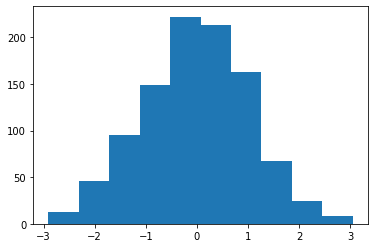

In [94]:
plt.hist(np.random.normal(loc=alpha_bias_random_mean, scale=alpha_random_stddev, size=n_repeats));

In [95]:
alpha_bias_random_mean = 10
alpha_random_stddev = 5
beta_random_stddev = 5

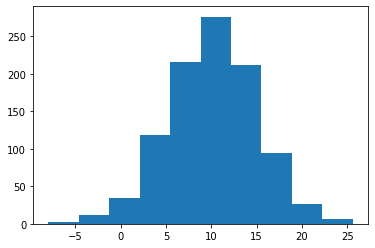

In [91]:
plt.hist(np.random.normal(loc=alpha_bias_random_mean, scale=alpha_random_stddev, size=n_repeats));

<b> Alpha regularization </b> 

It is recommended to use alpha regularization which penalizes the model for taking too high alpha values by addition of mean alpha multiplied by `alpha_reg` parameter to main loss.

`alpha_reg` value should be selected in accordance with main loss value and often is in range [1e-6; 1e-3]

## 2. Find appropriate ranges of hyperparameters for binary cross-entropy and contrastive model

<b>Goal: </b>  to define appropriate ranges for models hyperparameters

Proposed 2 models (binary cross-entropy and contrastive model) are produced by adding new components to main loss of base model. To evaluate scale of these components, here we fit base model, save prediction and evaluate new loss components with these predictions.

Firstly, fit base model and save predictions

In [4]:
import json

from custom_models import kkbox_main_network as custom_bottom
from train import *

In [5]:
config_path = '../data/config_kkbox.json'
custom_bottom_function_name = 'kkbox_main_network'
args = {
    'verbose': 0,
    'save_model': False
}

exec('from custom_models import ' + custom_bottom_function_name + ' as custom_bottom')
with open(config_path, 'rb') as f:
    config = json.load(f)

In [7]:
config.update({'n_epochs': 1})

In [8]:
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 1e-07,
 'n_epochs': 1,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001}

In [ ]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='base', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_val, pred_train, pred_val = train(
    args=args, train_data=data['train'], val_data=None, config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

In [168]:
pred = pred_train[-1]

In [173]:
with open("../tmp/train_pred.pkl", 'wb') as f:
    pickle.dump(pred, f)

In [110]:
# %load_ext autoreload
# %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Binary cross-entropy model

In [9]:
from losses import batch_hard_sampling_cross_entropy_loss
from batch_generators_hard_mining import DataGenerator

In [193]:
tf.reset_default_graph()
o1_pl = tf.placeholder(dtype=tf.float64, name='o1')
target_pl = tf.placeholder(dtype=tf.float64, name='target')
t_pl = tf.placeholder(dtype=tf.float64, name='t')
y_pl = tf.placeholder(dtype=tf.float64, name='y')

hardest_pos, hardest_neg, mean_ce_loss = batch_hard_sampling_cross_entropy_loss(o1_pl, target_pl, t_pl, y_pl)

In [210]:
dg = DataGenerator(x=data['train']['x'],
                   y=data['train']['y'],
                   t=data['train']['t'],
                   n_ex_bin=config['n_ex_bin'],
                   n_time_bins=config['n_time_bins'])
gen = dg.get_batch()
losses = []
with tf.Session() as sess:
    tf.set_random_seed(s)
    init = tf.initialize_all_variables()
    sess.run(init)
    while True:
        try:
            x_batch, y_batch, target, ind_examples = next(gen)
            increm = sess.run(mean_ce_loss, feed_dict={
                o1_pl: pred[ind_examples], 
                t_pl: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                y_pl: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                target_pl: target.reshape((y_batch[:, 0].shape[0], 1))
            })
            losses.append(increm)
        except StopIteration:
            break

In [216]:
np.mean(np.array(losses))

0.97254664

### Contrastive model

Set margin to 1 and Contrastive weight to small value

In [10]:
print("Margin weight: {}".format(config['margin_weight']))
print("Contrastive weight: {}".format(config['contrastive_weight']))

Margin weight: 1
Contrastive weight: 1e-07


In [11]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

train_data = data['train']
val_data = None
seed = config['seed']

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
### the same as train function from train.py, but get_batch_loss is estimated for each loss component separately

# determine optimizer
train_op, global_step = initialize_sgd_optimizer(config, model)
# TODO: increment_global_step is not needed???
increment_global_step = tf.assign(global_step, global_step + 1)
# lists to store results
hist_losses_train_main = []
hist_losses_train_additional = []
# hist_losses_val = []
all_pred_train = []
# all_pred_val = []
with tf.Session() as sess:
    tf.set_random_seed(seed)
    init = tf.initialize_all_variables()
    sess.run(init)
    # for each epoch
    for i in tqdm.tqdm(range(config['n_epochs'])):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss = sess.run([train_op, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        pred_train_transformed = sess.run(model.o1_transformed, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        
        # CHANGE: 
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, model.additional_loss)
        hist_losses_train_additional.append(train_loss[0])
        train_loss = get_loss_batch(train_data, config, sess, model.main_loss)
        hist_losses_train_main.append(train_loss[0])




Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 1/1 [15:17<00:00, 917.44s/it]


In [13]:
np.mean(all_pred_train[0], axis=0)

array([7.347605e+02, 6.973734e-01], dtype=float32)

In [14]:
hist_losses_train_main[0]

1.3937495

In [15]:
hist_losses_train_additional[0] / config['contrastive_weight']

1266.5776011999696

In [16]:
np.mean(pred_train, axis=0)

array([7.347605e+02, 6.973734e-01], dtype=float32)

In [17]:
np.mean(pred_train_transformed, axis=0)

array([-575.64984, -554.8899 ], dtype=float32)

In [18]:
np.median(pred_train_transformed, axis=0)

array([-245.07549, -236.31842], dtype=float32)

In [19]:
np.min(pred_train_transformed, axis=0)

array([-81262.516, -78126.875], dtype=float32)

In [20]:
np.max(pred_train_transformed, axis=0)

array([-1.4754547, -2.1232765], dtype=float32)

How margin weight impact on additional loss

In [38]:
config.update({'margin_weight': 0.1})

In [39]:
print("Margin weight: {}".format(config['margin_weight']))
print("Contrastive weight: {}".format(config['contrastive_weight']))

Margin weight: 0.1
Contrastive weight: 1e-07


In [40]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

train_data = data['train']
val_data = None
seed = config['seed']

In [41]:
### the same as train function from train.py, but get_batch_loss is estimated for each loss component separately

# determine optimizer
train_op, global_step = initialize_sgd_optimizer(config, model)
# TODO: increment_global_step is not needed???
increment_global_step = tf.assign(global_step, global_step + 1)
# lists to store results
hist_losses_train_main = []
hist_losses_train_additional = []
# hist_losses_val = []
all_pred_train = []
# all_pred_val = []
with tf.Session() as sess:
    tf.set_random_seed(seed)
    init = tf.initialize_all_variables()
    sess.run(init)
    # for each epoch
    for i in tqdm.tqdm(range(config['n_epochs'])):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss = sess.run([train_op, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        
        # CHANGE: 
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, model.additional_loss)
        hist_losses_train_additional.append(train_loss)
        train_loss = get_loss_batch(train_data, config, sess, model.main_loss)
        hist_losses_train_main.append(train_loss)



100%|██████████| 1/1 [14:11<00:00, 851.13s/it]


In [42]:
np.mean(all_pred_train[0], axis=0)

array([7.3366833e+02, 6.9737333e-01], dtype=float32)

In [43]:
hist_losses_train_main[0]

1.3937204

In [44]:
hist_losses_train_additional[0] / config['contrastive_weight']

1496.047480031848

In [45]:
config.update({'margin_weight': 10})

In [46]:
print("Margin weight: {}".format(config['margin_weight']))
print("Contrastive weight: {}".format(config['contrastive_weight']))

Margin weight: 10
Contrastive weight: 1e-07


In [47]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

train_data = data['train']
val_data = None
seed = config['seed']

In [48]:
### the same as train function from train.py, but get_batch_loss is estimated for each loss component separately

# determine optimizer
train_op, global_step = initialize_sgd_optimizer(config, model)
# TODO: increment_global_step is not needed???
increment_global_step = tf.assign(global_step, global_step + 1)
# lists to store results
hist_losses_train_main = []
hist_losses_train_additional = []
# hist_losses_val = []
all_pred_train = []
# all_pred_val = []
with tf.Session() as sess:
    tf.set_random_seed(seed)
    init = tf.initialize_all_variables()
    sess.run(init)
    # for each epoch
    for i in tqdm.tqdm(range(config['n_epochs'])):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss = sess.run([train_op, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        
        # CHANGE: 
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, model.additional_loss)
        hist_losses_train_additional.append(train_loss)
        train_loss = get_loss_batch(train_data, config, sess, model.main_loss)
        hist_losses_train_main.append(train_loss)



100%|██████████| 1/1 [14:12<00:00, 852.95s/it]


In [49]:
np.mean(all_pred_train[0], axis=0)

array([7.3474103e+02, 6.9737333e-01], dtype=float32)

In [50]:
hist_losses_train_main[0]

1.3937762

In [51]:
hist_losses_train_additional[0] / config['contrastive_weight']

1048.0065975571051

In [52]:
config.update({'margin_weight': 100})

In [53]:
print("Margin weight: {}".format(config['margin_weight']))
print("Contrastive weight: {}".format(config['contrastive_weight']))

Margin weight: 100
Contrastive weight: 1e-07


In [54]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

train_data = data['train']
val_data = None
seed = config['seed']

In [55]:
### the same as train function from train.py, but get_batch_loss is estimated for each loss component separately

# determine optimizer
train_op, global_step = initialize_sgd_optimizer(config, model)
# TODO: increment_global_step is not needed???
increment_global_step = tf.assign(global_step, global_step + 1)
# lists to store results
hist_losses_train_main = []
hist_losses_train_additional = []
# hist_losses_val = []
all_pred_train = []
# all_pred_val = []
with tf.Session() as sess:
    tf.set_random_seed(seed)
    init = tf.initialize_all_variables()
    sess.run(init)
    # for each epoch
    for i in tqdm.tqdm(range(config['n_epochs'])):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss = sess.run([train_op, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        
        # CHANGE: 
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, model.additional_loss)
        hist_losses_train_additional.append(train_loss)
        train_loss = get_loss_batch(train_data, config, sess, model.main_loss)
        hist_losses_train_main.append(train_loss)



100%|██████████| 1/1 [14:07<00:00, 847.10s/it]


In [56]:
np.mean(all_pred_train[0], axis=0)

array([7.3537854e+02, 6.9737333e-01], dtype=float32)

In [57]:
hist_losses_train_main[0]

1.3937583

In [58]:
hist_losses_train_additional[0] / config['contrastive_weight']

1064.341195160523

### Contrastive sequential

In [53]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

train_data = data['train']
val_data = None
seed = config['seed']

In [54]:
config['n_epochs'] = 2
config['n_epochs_contr'] = 2
config['n_epochs_both'] = 2
config['contrastive_weight'] = 0.1

config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.1,
 'n_epochs': 2,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 2,
 'n_epochs_both': 2}

In [55]:
def run_step(sess, data_gen, model, train_op, n_epochs, val_data=None):
    
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val

def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w = initialize_sgd_optimizer(config, model, optimize_only_main_loss=True, var_list=trainable_binary)
    train_op_c, global_step_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr)
    train_op_w_c, global_step_w_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary)
    # TODO: increment_global_step is not needed???
#     increment_global_step = tf.assign(global_step_w, global_step_w + 1)
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        # optimize main loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w, config['n_epochs'], val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 1: ", hist_losses_val)
        print("val main loss after step 1: ", hist_losses_main_val)
        
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_c, config['n_epochs_contr'], val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w_c, config['n_epochs_both'], val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        
        # save model
        if args['verbose'] == 1:
            print("Save model...")
        saver = tf.train.Saver()
        if args['save_model']:
            saver.save(sess, args['save_path'] + args["model_type"] + "_model")
    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val

def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();


In [56]:
# hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
#     args=args, train_data=data['train'], val_data=None, config=config,
#     data_gen=data_gen, model=model, seed=config['seed'])

# all_q = []
# for pred in all_pred_train:
#     all_q.append(test_quality(t_true=data['train']['t'], y_true=data['train']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=103))
# df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

  0%|          | 0/2 [00:00<?, ?it/s]

val loss after step 1:  []
val main loss after step 1:  []


  0%|          | 0/2 [00:00<?, ?it/s]

val loss after step 2:  []
val main loss after step 2:  []


100%|██████████| 2/2 [21:02<00:00, 631.38s/it]


val loss after step 3:  []
val main loss after step 3:  []


AssertionError: Need all input to be np.ndarrays

In [57]:
hist_losses_train

[130.13739, 129.74756, 5.92159, 7.6956806, 1.7626593, 1.6148101]

In [58]:
hist_losses_main_train

[1.3940763, 1.3780881, 1.3776889, 1.3777618, 1.4467003, 1.455874]

In [59]:
all_q

[]

In [ ]:
all_q = []
for pred in tqdm.tqdm_notebook(all_pred_train):
    all_q.append(test_quality(t_true=data['train']['t'], y_true=data['train']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=103))
df_all_q = pd.concat(all_q)

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


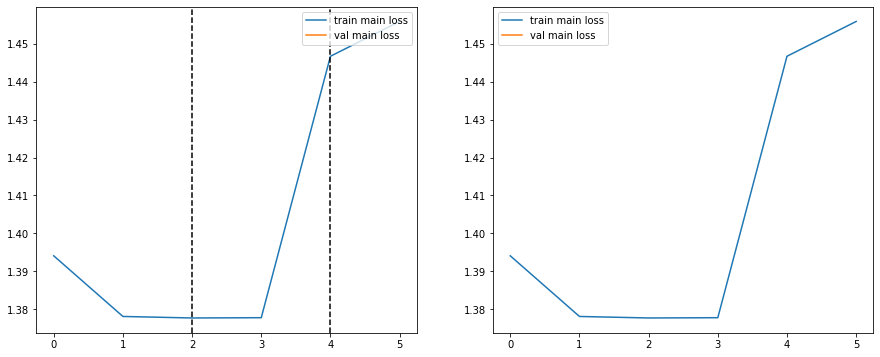

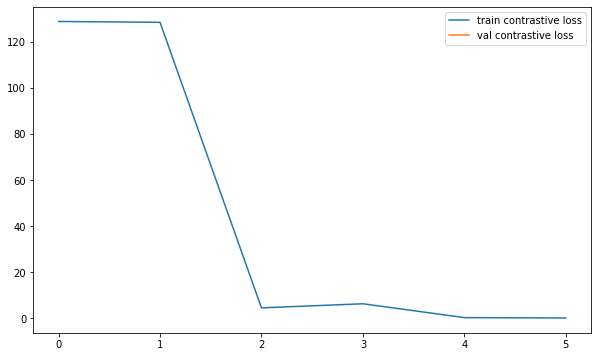

KeyError: 'dt_c_index'

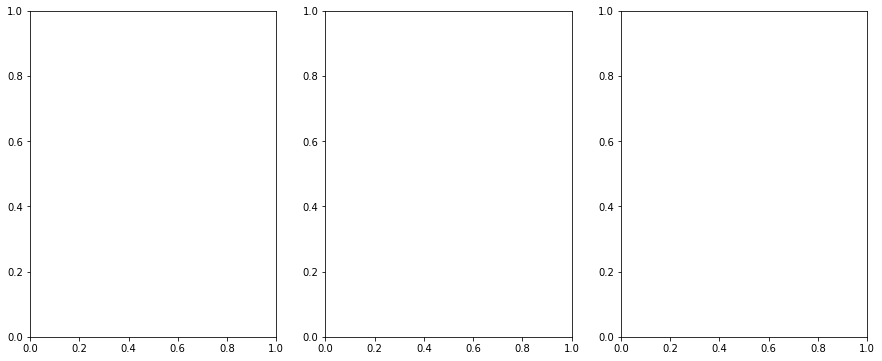

In [64]:
plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [25]:
config.update(
    {
        'n_epochs': 10,
        'n_epochs_contr': 5,
        'n_epochs_both': 10,
        'contrastive_weight': 0.5,
        'learning_rate': 0.001,
        'learning_rate_contr': 0.0005,
        'learning_rate_both': 0.00005
    }
)
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.5,
 'n_epochs': 10,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 5,
 'n_epochs_both': 10,
 'learning_rate_contr': 0.0005,
 'learning_rate_both': 5e-05,
 'momentum': 0.7}

In [24]:
def run_step(sess, data_gen, model, train_op, n_epochs, train_data, val_data=None):
    try:
        print(train_op._lr)
    except:
        print('no _lr attribute')
        
    try:
        print(train_op._learning_rate)
    except:
        print('no _learning_rate attribute')
        
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val


def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends=''):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step


def run_step(sess, data_gen, model, train_op, n_epochs, train_data, val_data=None):
       
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val


def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w = initialize_sgd_optimizer(config, model, optimize_only_main_loss=True, var_list=trainable_binary)
    train_op_c, global_step_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr')
    train_op_w_c, global_step_w_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both')
    # TODO: increment_global_step is not needed???
#     increment_global_step = tf.assign(global_step_w, global_step_w + 1)
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        # optimize main loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w, config['n_epochs'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 1: ", hist_losses_val)
        print("val main loss after step 1: ", hist_losses_main_val)
        
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        
        # save model
        if args['verbose'] == 1:
            print("Save model...")
        saver = tf.train.Saver()
        if args['save_model']:
            saver.save(sess, args['save_path'] + args["model_type"] + "_model")
    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val

def plot_results(train_main_loss, val_main_loss, train_loss, val_loss, df_all_q, n_epochs=[1, 1, 1]):
    # main
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(train_main_loss, label='train main loss')
    ax[0].plot(val_main_loss, label='val main loss')
    ax[0].legend(loc=1)
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(train_main_loss[round(len(val_main_loss) / 2):], label='train main loss')
    ax[1].plot(val_main_loss[round(len(val_main_loss) / 2):], label='val main loss')
    ax[1].legend(loc=2)    
    plt.show();
    
    # additional loss
    train_add_loss = [train_loss[i] - train_main_loss[i] for i in range(len(train_loss))]
    val_add_loss = [val_loss[i] - val_main_loss[i] for i in range(len(val_loss))]
    plt.figure(figsize=(10, 6))
    plt.plot(train_add_loss, label='train contrastive loss')
    plt.plot(val_add_loss, label='val contrastive loss')
    plt.legend(loc=1)  
    plt.show();
    
    # metrics
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values)
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0], c='black', linestyle='--')
    ax[0].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values)
    ax[1].axvline(n_epochs[0], c='black', linestyle='--')
    ax[1].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values)
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0], c='black', linestyle='--')
    ax[2].axvline(n_epochs[0] + n_epochs[1], c='black', linestyle='--')
    plt.show();
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    ax[0].plot(df_all_q['dt_c_index'].values[round(len(val_main_loss) / 2):])
    ax[0].set_title('dt_c_index')
    ax[0].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].plot(df_all_q['int_brier_score'].values[round(len(val_main_loss) / 2):])
    ax[1].axvline(n_epochs[0] + n_epochs[1] -round(len(val_main_loss) / 2), c='black', linestyle='--')
    ax[1].set_title('int_brier_score')
    ax[2].plot(df_all_q['int_nbill'].values[round(len(val_main_loss) / 2):])
    ax[2].set_title('int_nbill')
    ax[2].axvline(n_epochs[0] + n_epochs[1] - round(len(val_main_loss) / 2), c='black', linestyle='--')
    plt.show();



100%|██████████| 10/10 [1:44:04<00:00, 624.49s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

val loss after step 1:  [638.74097, 658.86786, 716.0289, 636.7491, 741.83936, 830.26074, 774.8449, 775.5144, 636.3783, 647.33167]
val main loss after step 1:  [1.3913784, 1.3728542, 1.3678375, 1.3667041, 1.3630244, 1.3581303, 1.3580462, 1.3555796, 1.3579957, 1.3563262]



100%|██████████| 5/5 [51:44<00:00, 620.99s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

val loss after step 2:  [638.74097, 658.86786, 716.0289, 636.7491, 741.83936, 830.26074, 774.8449, 775.5144, 636.3783, 647.33167, 75.05529, 70.214, 13.80359, 34.04853, 96.189514]
val main loss after step 2:  [1.3913784, 1.3728542, 1.3678375, 1.3667041, 1.3630244, 1.3581303, 1.3580462, 1.3555796, 1.3579957, 1.3563262, 1.3566812, 1.3572959, 1.357083, 1.3567649, 1.3589226]



100%|██████████| 10/10 [1:45:17<00:00, 631.74s/it]


val loss after step 3:  [638.74097, 658.86786, 716.0289, 636.7491, 741.83936, 830.26074, 774.8449, 775.5144, 636.3783, 647.33167, 75.05529, 70.214, 13.80359, 34.04853, 96.189514, 2.0090559, 1.9293878, 1.9847667, 1.9209332, 1.7627766, 1.9552802, 1.9283704, 1.8557799, 1.8482336, 1.7983363]
val main loss after step 3:  [1.3913784, 1.3728542, 1.3678375, 1.3667041, 1.3630244, 1.3581303, 1.3580462, 1.3555796, 1.3579957, 1.3563262, 1.3566812, 1.3572959, 1.357083, 1.3567649, 1.3589226, 1.4739457, 1.4656107, 1.4631015, 1.4588261, 1.4557657, 1.4516606, 1.4522935, 1.4529454, 1.4517089, 1.4505401]


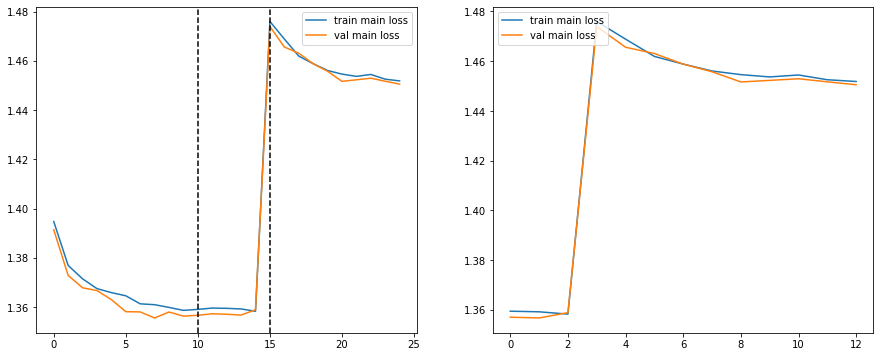

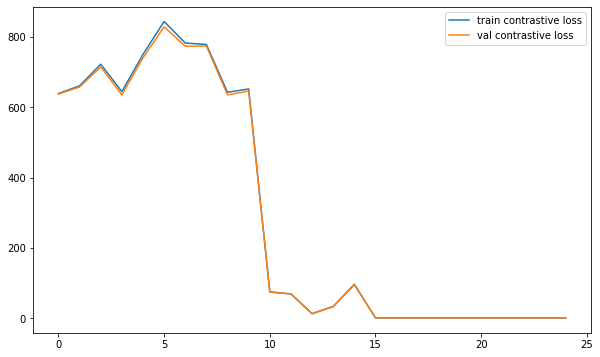

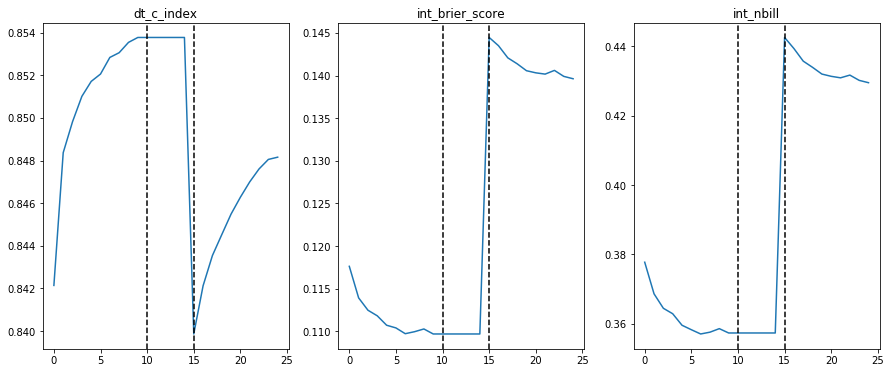

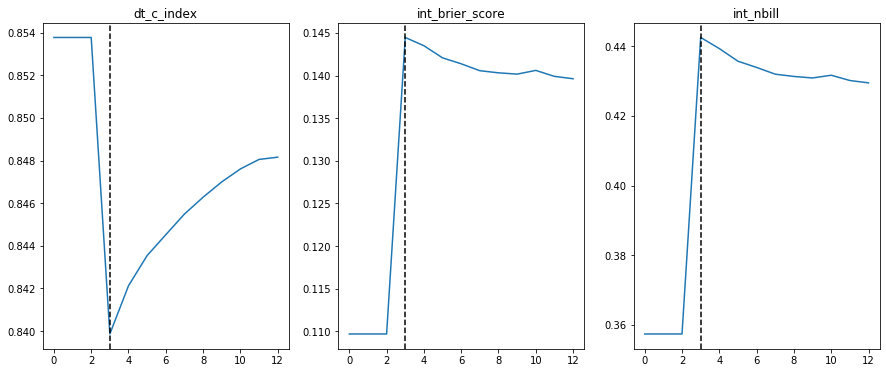

In [11]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

In [ ]:
# more contrastive only epochs with lower learning rate

In [12]:
config.update(
    {
        'n_epochs': 15,
        'n_epochs_contr': 15,
        'n_epochs_both': 15,
        'contrastive_weight': 0.5,
        'learning_rate': 0.001,
        'learning_rate_contr': 0.0001,
        'learning_rate_both': 0.00005
    }
)
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.5,
 'n_epochs': 15,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 15,
 'n_epochs_both': 15,
 'learning_rate_contr': 0.0001,
 'learning_rate_both': 5e-05}


100%|██████████| 15/15 [2:35:23<00:00, 621.57s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 1:  [636.39087, 657.3622, 716.0104, 639.791, 743.5253, 835.0869, 775.4484, 775.5888, 635.91284, 646.54266, 782.05347, 667.8356, 814.5614, 694.13983, 764.24445]
val main loss after step 1:  [1.3913794, 1.3728627, 1.3678886, 1.3667048, 1.3630308, 1.3581444, 1.3580055, 1.3555646, 1.3579334, 1.3563052, 1.3561608, 1.3558335, 1.3552676, 1.3540721, 1.3559924]



100%|██████████| 15/15 [2:35:13<00:00, 620.90s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [636.39087, 657.3622, 716.0104, 639.791, 743.5253, 835.0869, 775.4484, 775.5888, 635.91284, 646.54266, 782.05347, 667.8356, 814.5614, 694.13983, 764.24445, 12.872789, 10.057072, 12.892696, 23.036411, 5.538097, 29.943872, 28.12464, 4.989015, 33.89131, 2.5689595, 33.91359, 30.225782, 14.686262, 15.816153, 11.727137]
val main loss after step 2:  [1.3913794, 1.3728627, 1.3678886, 1.3667048, 1.3630308, 1.3581444, 1.3580055, 1.3555646, 1.3579334, 1.3563052, 1.3561608, 1.3558335, 1.3552676, 1.3540721, 1.3559924, 1.3531677, 1.3519682, 1.3557075, 1.3541864, 1.355319, 1.3520082, 1.3533896, 1.3523366, 1.3545035, 1.3537381, 1.3557632, 1.3548177, 1.353016, 1.3579359, 1.3532704]



100%|██████████| 15/15 [2:37:29<00:00, 629.98s/it]


val loss after step 3:  [636.39087, 657.3622, 716.0104, 639.791, 743.5253, 835.0869, 775.4484, 775.5888, 635.91284, 646.54266, 782.05347, 667.8356, 814.5614, 694.13983, 764.24445, 12.872789, 10.057072, 12.892696, 23.036411, 5.538097, 29.943872, 28.12464, 4.989015, 33.89131, 2.5689595, 33.91359, 30.225782, 14.686262, 15.816153, 11.727137, 1.9906431, 1.816184, 1.9902824, 2.027881, 1.858174, 1.8013728, 2.0361063, 1.7530184, 1.8579798, 1.9672085, 1.8976961, 1.8991872, 1.9522828, 1.9081935, 2.0199878]
val main loss after step 3:  [1.3913794, 1.3728627, 1.3678886, 1.3667048, 1.3630308, 1.3581444, 1.3580055, 1.3555646, 1.3579334, 1.3563052, 1.3561608, 1.3558335, 1.3552676, 1.3540721, 1.3559924, 1.3531677, 1.3519682, 1.3557075, 1.3541864, 1.355319, 1.3520082, 1.3533896, 1.3523366, 1.3545035, 1.3537381, 1.3557632, 1.3548177, 1.353016, 1.3579359, 1.3532704, 1.4505311, 1.4456285, 1.4437009, 1.4444764, 1.4446119, 1.444051, 1.4444274, 1.4395487, 1.4428177, 1.4403757, 1.4402876, 1.4417241, 1.441677,

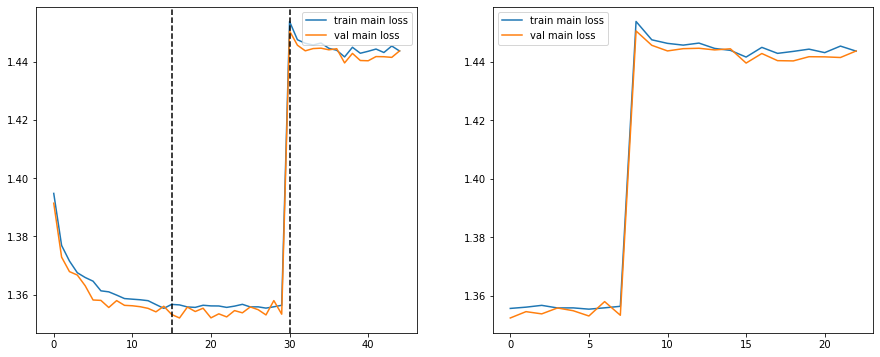

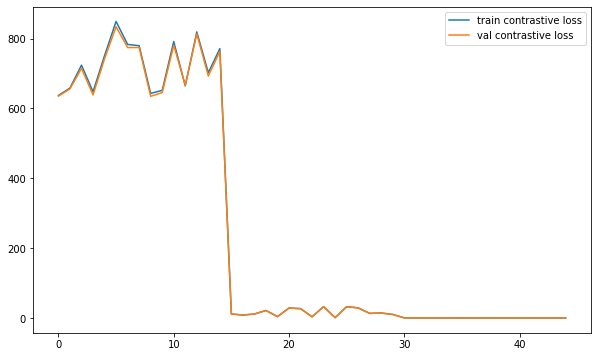

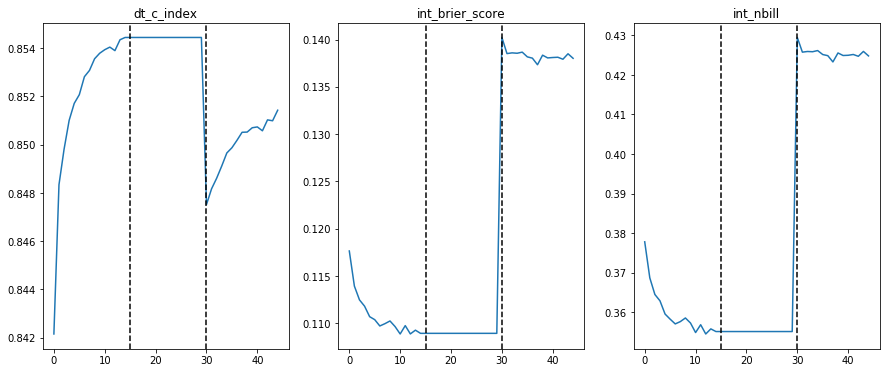

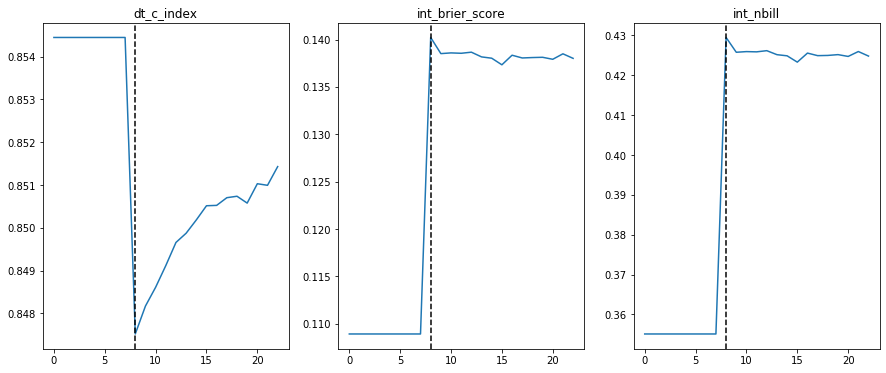

In [13]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

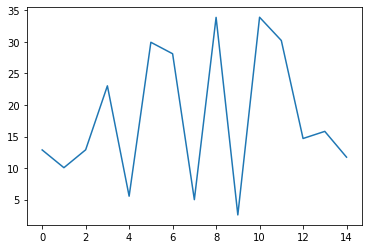

In [14]:
plt.plot([12.872789, 10.057072, 12.892696, 23.036411, 5.538097, 29.943872, 28.12464, 4.989015, 33.89131, 2.5689595, 33.91359, 30.225782, 14.686262, 15.816153, 11.727137])

In [15]:
# more contrastive only epochs with lower learning rate

In [17]:
config.update(
    {
        'n_epochs': 15,
        'n_epochs_contr': 25,
        'n_epochs_both': 15,
        'contrastive_weight': 0.5,
        'learning_rate': 0.001,
        'learning_rate_contr': 0.00005,
        'learning_rate_both': 0.00005
    }
)
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.5,
 'n_epochs': 15,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 25,
 'n_epochs_both': 15,
 'learning_rate_contr': 5e-05,
 'learning_rate_both': 5e-05}


100%|██████████| 15/15 [2:35:33<00:00, 622.24s/it]

  0%|          | 0/25 [00:00<?, ?it/s]

val loss after step 1:  [640.5293, 656.7477, 714.89246, 637.3976, 743.193, 834.83844, 772.3578, 779.2837, 638.8825, 651.32245, 787.14453, 668.0813, 821.0937, 697.318, 772.83124]
val main loss after step 1:  [1.3913472, 1.3728555, 1.3678316, 1.3667198, 1.3630215, 1.3581115, 1.3579955, 1.3555427, 1.3579335, 1.3562533, 1.3561443, 1.3557633, 1.3553253, 1.354041, 1.3558673]



100%|██████████| 25/25 [4:18:27<00:00, 620.32s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [640.5293, 656.7477, 714.89246, 637.3976, 743.193, 834.83844, 772.3578, 779.2837, 638.8825, 651.32245, 787.14453, 668.0813, 821.0937, 697.318, 772.83124, 7.114382, 4.999402, 7.7310166, 12.670694, 3.7064395, 15.754023, 15.488012, 4.372322, 17.612501, 3.1883044, 18.506329, 16.525434, 7.3710494, 7.8307085, 7.5166106, 13.185994, 5.8078995, 5.0916867, 14.177701, 18.219402, 9.251305, 16.823662, 1.7894095, 4.3111286, 16.122849]
val main loss after step 2:  [1.3913472, 1.3728555, 1.3678316, 1.3667198, 1.3630215, 1.3581115, 1.3579955, 1.3555427, 1.3579335, 1.3562533, 1.3561443, 1.3557633, 1.3553253, 1.354041, 1.3558673, 1.3530414, 1.3518504, 1.3555636, 1.3540262, 1.355194, 1.3518558, 1.3532512, 1.3522387, 1.3543653, 1.3536135, 1.3555921, 1.3547033, 1.3528508, 1.3578342, 1.3531545, 1.3517257, 1.353514, 1.3512053, 1.3525976, 1.353127, 1.3527796, 1.3554894, 1.3523282, 1.3517514, 1.350611]



100%|██████████| 15/15 [2:37:27<00:00, 629.82s/it]


val loss after step 3:  [640.5293, 656.7477, 714.89246, 637.3976, 743.193, 834.83844, 772.3578, 779.2837, 638.8825, 651.32245, 787.14453, 668.0813, 821.0937, 697.318, 772.83124, 7.114382, 4.999402, 7.7310166, 12.670694, 3.7064395, 15.754023, 15.488012, 4.372322, 17.612501, 3.1883044, 18.506329, 16.525434, 7.3710494, 7.8307085, 7.5166106, 13.185994, 5.8078995, 5.0916867, 14.177701, 18.219402, 9.251305, 16.823662, 1.7894095, 4.3111286, 16.122849, 1.881236, 1.9092166, 2.006582, 1.9283695, 2.0317903, 2.0299096, 1.985166, 1.925665, 1.956378, 2.012293, 1.9866256, 2.0313385, 1.986062, 2.030227, 2.0298738]
val main loss after step 3:  [1.3913472, 1.3728555, 1.3678316, 1.3667198, 1.3630215, 1.3581115, 1.3579955, 1.3555427, 1.3579335, 1.3562533, 1.3561443, 1.3557633, 1.3553253, 1.354041, 1.3558673, 1.3530414, 1.3518504, 1.3555636, 1.3540262, 1.355194, 1.3518558, 1.3532512, 1.3522387, 1.3543653, 1.3536135, 1.3555921, 1.3547033, 1.3528508, 1.3578342, 1.3531545, 1.3517257, 1.353514, 1.3512053, 1.35

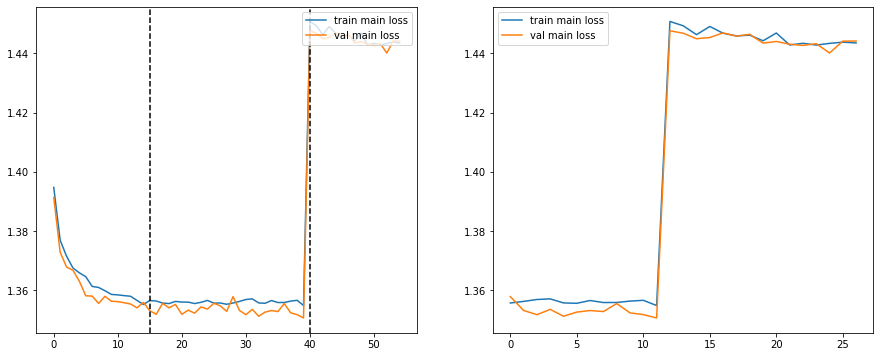

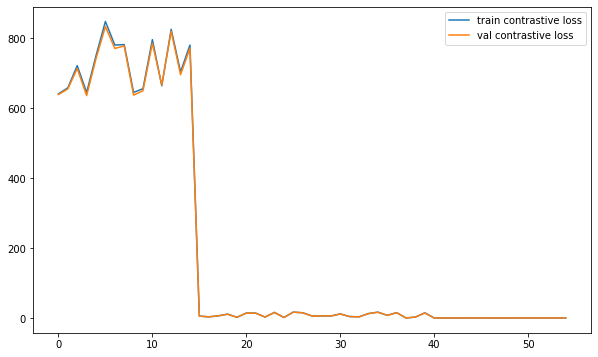

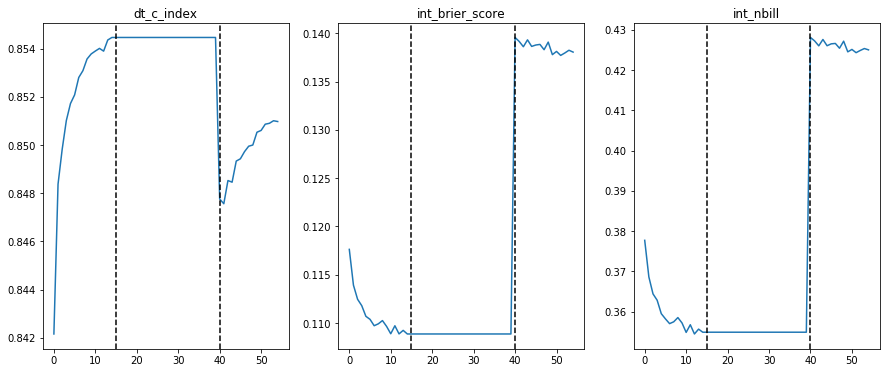

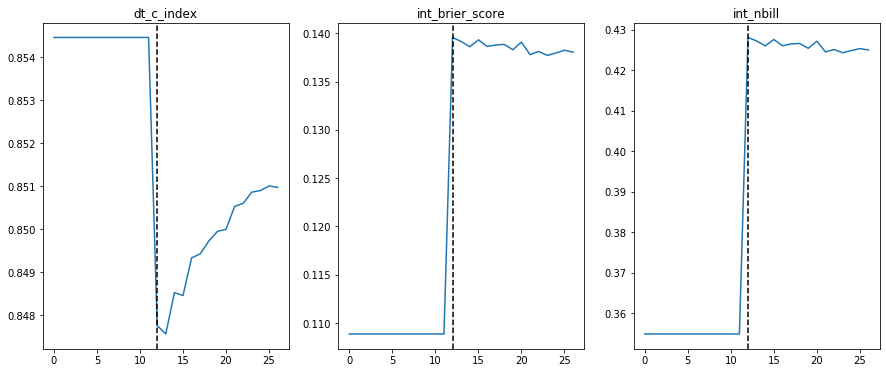

In [18]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )

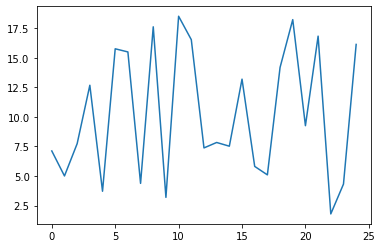

In [22]:
plt.plot([7.114382, 4.999402, 7.7310166, 12.670694, 3.7064395, 15.754023, 15.488012, 4.372322, 17.612501, 3.1883044, 18.506329, 16.525434, 7.3710494, 7.8307085, 7.5166106, 13.185994, 5.8078995, 5.0916867, 14.177701, 18.219402, 9.251305, 16.823662, 1.7894095, 4.3111286, 16.122849])

In [ ]:
# change 2 and 3 optimizer from sgd to momentum

In [30]:
args = {
    'verbose': 0,
    'save_model': True,
    'save_path': '../../',
    'model_type': 'mommentum'
}

config.update(
    {
        'n_epochs': 15,
        'n_epochs_contr': 25,
        'n_epochs_both': 15,
        'contrastive_weight': 0.5,
        'learning_rate': 0.001,
        'learning_rate_contr': 0.00005,
        'learning_rate_both': 0.00005,
        'momentum_both': 0.7,
        'momentum_contr': 0.7
    }
)
config

{'seed': 2,
 'alpha_reg': 1e-06,
 'alpha_bias_random_mean': 10,
 'alpha_random_stddev': 5,
 'beta_random_stddev': 5,
 'n_time_bins': 10,
 'time_grid': [30, 60, 90, 120, 150, 180, 210, 240, 270, 300],
 'n_ex_bin': 30,
 'cross_entropy_weight': 0.1,
 'margin_weight': 1,
 'contrastive_weight': 0.5,
 'n_epochs': 15,
 'val_n_ex_bin': 1000,
 'step_rate': 10,
 'decay': 0.9,
 'learning_rate': 0.001,
 'n_epochs_contr': 25,
 'n_epochs_both': 15,
 'learning_rate_contr': 5e-05,
 'learning_rate_both': 5e-05,
 'momentum': 0.7,
 'momentum_both': 0.7,
 'momentum_contr': 0.7}

In [31]:
def run_step(sess, data_gen, model, train_op, n_epochs, train_data, val_data=None):
    try:
        print(train_op._lr)
    except:
        print('no _lr attribute')
        
    try:
        print(train_op._learning_rate)
    except:
        print('no _learning_rate attribute')
        
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    # for each epoch
    for i in tqdm.tqdm(range(n_epochs)):
        # initialize generator
        gen = data_gen.get_batch()
        while True:
            try:
                # get batch data
                x_batch, y_batch, target, _ = next(gen)
                feed_dict = {
                    model.x: x_batch,
                    model.t: y_batch[:, 0].reshape((y_batch[:, 0].shape[0], 1)),
                    model.y: y_batch[:, 1].reshape((y_batch[:, 0].shape[0], 1)),
                    model.target: target.reshape((y_batch[:, 0].shape[0], 1)),
                }
                # train model on batch
                _, train_batch_loss_main, train_batch_loss = sess.run([train_op, model.main_loss, model.loss], feed_dict=feed_dict)
            except StopIteration:
                # if run out of examples
                break
        if val_data is not None:
            # get prediction for validation data
            pred_val = sess.run(model.o1, feed_dict={model.x: val_data['x']})
            all_pred_val.append(pred_val)
            # get loss for validation data
            # TODO: check with val_data not None: if error with placeholder - give to get_loss_batch model
            #  as argument inplace of tensor_loss
            val_loss = get_loss_batch(val_data, config, sess, [model.main_loss, model.loss])
            hist_losses_main_val.append(val_loss[0])
            hist_losses_val.append(val_loss[1])
            if args['verbose'] == 1:
                 print("Val loss at epoch {}: {}".format(i, val_loss))

        # get prediction for training data
        pred_train = sess.run(model.o1, feed_dict={model.x: train_data['x']})
        all_pred_train.append(pred_train)
        # get loss for training data
        train_loss = get_loss_batch(train_data, config, sess, [model.main_loss, model.loss])
        hist_losses_main_train.append(train_loss[0])
        hist_losses_train.append(train_loss[1])
    return all_pred_train, hist_losses_main_train, hist_losses_train, all_pred_val, hist_losses_main_val, hist_losses_val


def initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=None, params_ends='', opt_type='sgd'):
    """ Define GradientDescentOptimizer from config """

    global_step = tf.Variable(0, trainable=False)
    # if exponential decay of learning rate is specified in config
    if ('step_rate' + params_ends not in config.keys()) or (config['step_rate'  + params_ends] == 0) or (
            'decay'  + params_ends not in config.keys()) or (config['decay' + params_ends] == 1):
        learning_rate = config['learning_rate' + params_ends]
    else:
        learning_rate = tf.train.exponential_decay(
            config['learning_rate' + params_ends], global_step, config['step_rate' + params_ends], config['decay' + params_ends], staircase=True)
    if var_list is None:
        var_list = tf.global_variables()
    if opt_type == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    elif opt_type == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=config['momentum' + params_ends])
        
    if optimize_only_main_loss:
        train_op = optimizer.minimize(model.main_loss, var_list=var_list)
    else:
        train_op = optimizer.minimize(model.loss, var_list=var_list)
        
    return train_op, global_step



def train_sequential(args, train_data, config, data_gen, model, seed, val_data=None):
    # get trainable vars for each step
    trainable_binary = [var for var in tf.global_variables() if 'transform' not in var.name]
    trainable_contr = [var for var in tf.global_variables() if 'transform' in var.name]
    trainable_contr_binary = tf.global_variables()
    # determine optimizers for each step
    train_op_w, global_step_w = initialize_sgd_optimizer(config, model, optimize_only_main_loss=True, var_list=trainable_binary)
    train_op_c, global_step_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr, params_ends='_contr',
                                                        opt_type='momentum')
    train_op_w_c, global_step_w_c = initialize_sgd_optimizer(config, model, optimize_only_main_loss=False, var_list=trainable_contr_binary, params_ends='_both', 
                                                            opt_type='momentum')
    # TODO: increment_global_step is not needed???
#     increment_global_step = tf.assign(global_step_w, global_step_w + 1)
    # lists to store results
    hist_losses_train = []
    hist_losses_val = []
    hist_losses_main_train = []
    hist_losses_main_val = []
    all_pred_train = []
    all_pred_val = []
    
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        init = tf.initialize_all_variables()
        sess.run(init)
        
        # optimize main loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w, config['n_epochs'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 1: ", hist_losses_val)
        print("val main loss after step 1: ", hist_losses_main_val)
        
        # save model
        if args['verbose'] == 1:
            print("Save model...")
        saver = tf.train.Saver()
        if args['save_model']:
            saver.save(sess, args['save_path'] + args["model_type"] + "_model")
            
        # optimize contrastive loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_c, config['n_epochs_contr'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 2: ", hist_losses_val)
        print("val main loss after step 2: ", hist_losses_main_val)
        
        # optimize total loss
        (step_all_pred_train, step_hist_losses_main_train, step_hist_losses_train, step_all_pred_val, step_hist_losses_main_val, step_hist_losses_val) = run_step(
            sess, data_gen, model, train_op_w_c, config['n_epochs_both'], train_data, val_data=val_data)
        hist_losses_train.extend(step_hist_losses_train)
        hist_losses_val.extend(step_hist_losses_val)
        hist_losses_main_train.extend(step_hist_losses_main_train)
        hist_losses_main_val.extend(step_hist_losses_main_val)
        all_pred_train.extend(step_all_pred_train)
        all_pred_val.extend(step_all_pred_val)
        print("val loss after step 3: ", hist_losses_val)
        print("val main loss after step 3: ", hist_losses_main_val)
        

    return hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val


  0%|          | 0/15 [00:00<?, ?it/s]

no _lr attribute
no _learning_rate attribute



100%|██████████| 15/15 [2:36:38<00:00, 626.57s/it]


val loss after step 1:  [637.9819, 658.32495, 716.57513, 637.804, 740.3634, 832.9763, 776.95496, 780.60657, 637.9067, 649.1888, 791.6991, 669.4748, 814.683, 692.27094, 776.5795]
val main loss after step 1:  [1.39141, 1.3728678, 1.3678237, 1.3667151, 1.3630072, 1.3581207, 1.3580251, 1.3555369, 1.3579371, 1.3562922, 1.3561943, 1.3557761, 1.3552278, 1.3540303, 1.3558804]



  0%|          | 0/25 [00:00<?, ?it/s]

no _lr attribute
no _learning_rate attribute



100%|██████████| 25/25 [4:19:46<00:00, 623.44s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

val loss after step 2:  [637.9819, 658.32495, 716.57513, 637.804, 740.3634, 832.9763, 776.95496, 780.60657, 637.9067, 649.1888, 791.6991, 669.4748, 814.683, 692.27094, 776.5795, 8.437896, 15.431078, 7.9325657, 2.0390618, 1.8675573, 3.3003068, 8.781172, 17.563572, 13.209598, 24.121632, 29.220873, 14.816155, 2.468654, 7.0648317, 16.241966, 2.5569685, 11.788634, 4.6895127, 20.482239, 5.3838353, 12.808748, 12.637777, 10.337015, 3.9910266, 14.582473]
val main loss after step 2:  [1.39141, 1.3728678, 1.3678237, 1.3667151, 1.3630072, 1.3581207, 1.3580251, 1.3555369, 1.3579371, 1.3562922, 1.3561943, 1.3557761, 1.3552278, 1.3540303, 1.3558804, 1.3530295, 1.3518513, 1.3555821, 1.354045, 1.3552074, 1.3518478, 1.3532727, 1.352228, 1.3543731, 1.3536215, 1.3556029, 1.354708, 1.3528545, 1.3578448, 1.3531846, 1.3517257, 1.3535082, 1.3511984, 1.3525763, 1.3531209, 1.3527828, 1.3554853, 1.3523344, 1.3517495, 1.3506285]
no _lr attribute
no _learning_rate attribute



100%|██████████| 15/15 [2:38:23<00:00, 633.55s/it]


val loss after step 3:  [637.9819, 658.32495, 716.57513, 637.804, 740.3634, 832.9763, 776.95496, 780.60657, 637.9067, 649.1888, 791.6991, 669.4748, 814.683, 692.27094, 776.5795, 8.437896, 15.431078, 7.9325657, 2.0390618, 1.8675573, 3.3003068, 8.781172, 17.563572, 13.209598, 24.121632, 29.220873, 14.816155, 2.468654, 7.0648317, 16.241966, 2.5569685, 11.788634, 4.6895127, 20.482239, 5.3838353, 12.808748, 12.637777, 10.337015, 3.9910266, 14.582473, 1.9750891, 1.8542848, 1.908343, 1.9005849, 1.8193882, 2.2032394, 1.9476558, 1.7687378, 1.8429251, 1.8680478, 2.0621722, 1.8559688, 1.9918553, 1.855804, 1.9949977]
val main loss after step 3:  [1.39141, 1.3728678, 1.3678237, 1.3667151, 1.3630072, 1.3581207, 1.3580251, 1.3555369, 1.3579371, 1.3562922, 1.3561943, 1.3557761, 1.3552278, 1.3540303, 1.3558804, 1.3530295, 1.3518513, 1.3555821, 1.354045, 1.3552074, 1.3518478, 1.3532727, 1.352228, 1.3543731, 1.3536215, 1.3556029, 1.354708, 1.3528545, 1.3578448, 1.3531846, 1.3517257, 1.3535082, 1.3511984,

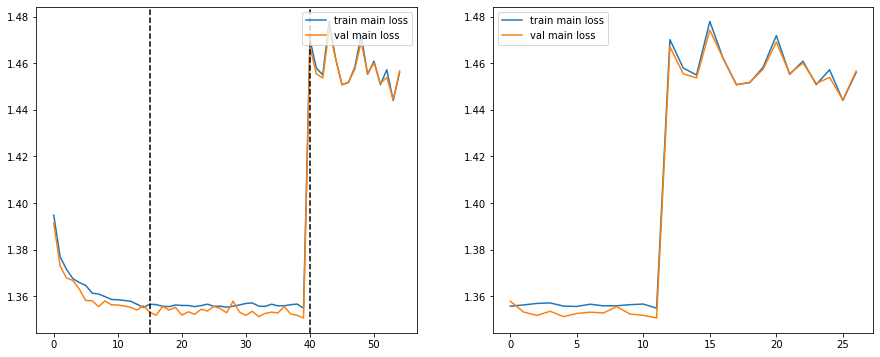

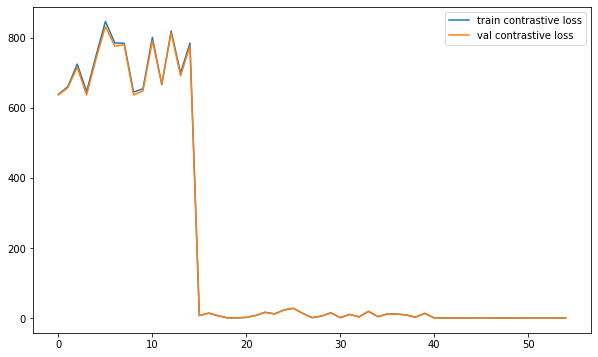

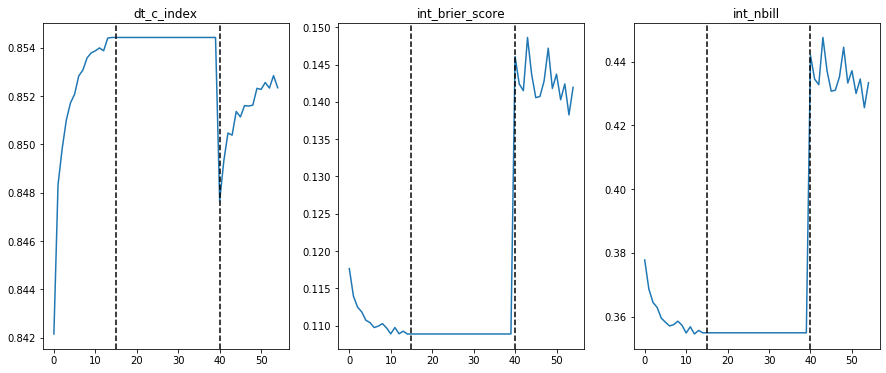

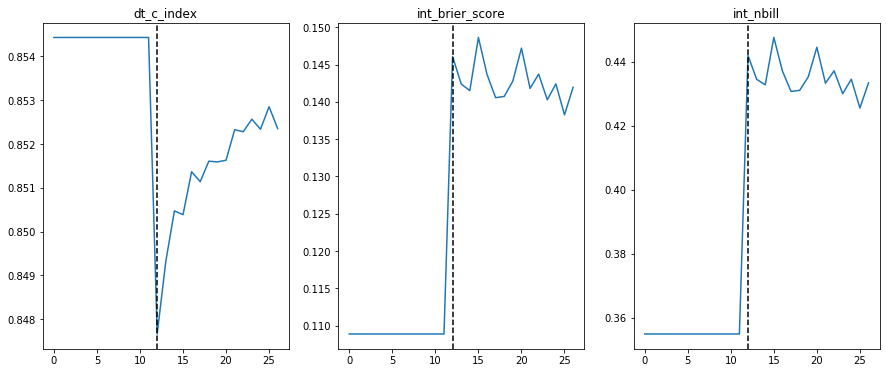

In [32]:
tf.reset_default_graph()

data_gen, model = initialize_model(
    model_type='contrastive', train_data=data['train'], config=config, custom_bottom=custom_bottom, seed=config['seed'])

hist_losses_train, hist_losses_main_train, hist_losses_val, hist_losses_main_val, all_pred_train, all_pred_val = train_sequential(
    args=args, train_data=data['train'], val_data=data['val'], config=config,
    data_gen=data_gen, model=model, seed=config['seed'])

all_q = []
for pred in all_pred_val:
    all_q.append(test_quality(
        t_true=data['val']['t'], y_true=data['val']['y'], pred=pred, time_grid=np.array(config['time_grid']), concordance_at_t=None, plot=False)
                )
df_all_q = pd.concat(all_q)

plot_results(hist_losses_main_train, hist_losses_main_val, hist_losses_train, hist_losses_val, df_all_q, 
             n_epochs=[config['n_epochs'], config['n_epochs_contr'], config['n_epochs_both']]
            )